# <center>DVH constraint optimization</center>


Dose Volume Histogram (DVH) constraints are frequently used in plan evaluations. However, implementing these constraints often leads to complex large-scale non-convex optimization problems (refer to [Mukherjee et al.2020](https://aapm.onlinelibrary.wiley.com/doi/epdf/10.1002/mp.13908) and its references for more information). Numerous heuristic strategies have been developed to resolve these optimization problems within a clinically acceptable timeframe. When developing new techniques, it's pertinent to ask, 'how close are we to the globally optimal solution?' This example aims to provide a benchmark globally optimal solution to address this query.

The optimization of DVH constraints can be fromulated as a Mixed Integer Programming (MIP) problem that can achieve the global optimal solution for smaller or medium-sized cases. These computationally intensive MIP problems can be tackled using down-sampled data or on high-performance computing platforms when time is not of the essence. The globally optimal solutions derived from MIP can then be used as benchmarks to validate and assist the development of more computationally effective methods.

Let's assume we need to add a DVH constraint of the form $V(d~Gy) \leq v \%$ for structure $s$ in the model. To construct the MIP problem, we first need to formulate a conventional IMRT optimization problem (refer to [basic_tutorial](http://localhost:8888/notebooks/examples/1_basic_tutorial.ipynb)). Next, we introduce a binary variable, $b_i$, which is assigned the value 1 if voxel $i$ receives a dose exceeding the specified threshold of $d$, and zero otherwise. We then implement a constraint that limits the number of voxels receiving a dose above the threshold, ensuring the DVH constraint is met. This can be achieved by adding the following constraints:



1- $\quad \mathbf{b}_i \in \{0,1\},~~\quad \quad A_{s,i}\mathbf{x} \leq {d} + \mathbf{b}_i\times M \quad \forall i \in I_s$.

Here, $I_s$ is a set of voxels belonging to structure $s$, and $M$ is a sufficiently large number. This constraint ensures that $b_i$ equals one if voxel $i$ receives a dose exceeding the dose threshold $d$.

2- $\quad \sum_{i \in I_s}\mathbf{b}_i \leq \frac{v}{100}$.

This limits the number of voxels receiving a dose above the threshold $d$ to be less than $v\%$ of the total.




In [1]:
import sys
sys.path.append('..\..')

In [2]:
import portpy.photon as pp
import matplotlib.pyplot as plt
import cvxpy as cp

### 1) Creating an IMRT plan without DVH constraints on down-sampled data
**Note:** When benchmarking your DVH constraint algorithm against the globally optimal solution derived from MIP, it's crucial to use downsampled data in both the MIP and your algorithm. This ensures a fair comparison. In this example, we are only comparing the plan without DVH constraints against the benchmark MIP plan. 

In [3]:
# Pick a patient
data_dir = r'../../data'
data = pp.DataExplorer(data_dir=data_dir)
patient_id = 'Lung_Phantom_Patient_1'
data.patient_id = patient_id

# Load ct, structure and beams objects
ct = pp.CT(data)
structs = pp.Structures(data)
beams = pp.Beams(data)

# Pick a protocol
protocol_name = 'Lung_2Gy_30Fx'
# Load clinical criteria for a specified protocol
clinical_criteria = pp.ClinicalCriteria(data, protocol_name=protocol_name)
# Load hyper-parameter values for optimization problem for a specified protocol
opt_params = data.load_config_opt_params(protocol_name=protocol_name)
# Create optimization structures (i.e., Rinds) 
structs.create_opt_structures(opt_params=opt_params)
# Load influence matrix
inf_matrix = pp.InfluenceMatrix(ct=ct, structs=structs, beams=beams)


# create down-sampled influence matrix 
voxel_down_sample_factors = [7, 7, 2]
opt_vox_xyz_res_mm = [ct_res * factor for ct_res, factor in zip(ct.get_ct_res_xyz_mm(), voxel_down_sample_factors)]
beamlet_down_sample_factor = 4
new_beamlet_width_mm = beams.get_finest_beamlet_width() * beamlet_down_sample_factor
new_beamlet_height_mm = beams.get_finest_beamlet_height() * beamlet_down_sample_factor

inf_matrix_dbv = inf_matrix.create_down_sample(beamlet_width_mm=new_beamlet_width_mm,
                                               beamlet_height_mm=new_beamlet_height_mm,
                                               opt_vox_xyz_res_mm=opt_vox_xyz_res_mm)

# create a plan

my_plan = pp.Plan(ct, structs, beams, inf_matrix_dbv, clinical_criteria)

# create a cvxpy optimization object
opt = pp.Optimization(my_plan, opt_params=opt_params)
opt.create_cvxpy_problem()
# solve the problem
sol_no_dvh = opt.solve(solver='MOSEK', verbose=False)

creating rinds.. This step may take some time due to dilation
rinds created!!
Creating BEV..
Loading sparse influence matrix...
Done
reindexing voxels...
parsing influence matrix for beam 0
parsing influence matrix for beam 1
parsing influence matrix for beam 2
parsing influence matrix for beam 3
parsing influence matrix for beam 4
parsing influence matrix for beam 5
parsing influence matrix for beam 6
creating influence matrix for down sample voxels..
Objective Start
Objective done
Constraints Start
Structure ESOPHAGUS not available!
Structure ESOPHAGUS not available!
Constraints done
Running Optimization..
Optimal value: 331.97656697742656
Elapsed time: 3.014655828475952 seconds


### 2) Obtaining the benchmark global optimal solution

In [4]:
# Add a dvh constraint V(10Gy) <= 15% for CORD as shown below
dvh_org = 'CORD'
dose_gy =  10
limit_volume_perc = 15

# extract data for dvh constraint
A = inf_matrix_dbv.A # down sample influence matrix
x = opt.vars['x'] # optimization variable
M = 50 # set Big M for dvh constraint
# Get fraction of organ volume inside the dose calculation box.  

# Add binary variables and constraints for dvh constraint
b = cp.Variable(
    len(inf_matrix_dbv.get_opt_voxels_idx('CORD')),
    boolean=True)
opt.constraints += [
    A[inf_matrix_dbv.get_opt_voxels_idx(dvh_org), :] @ x <= dose_gy / my_plan.get_num_of_fractions()
    + b * M]
opt.constraints += [b @ inf_matrix_dbv.get_opt_voxels_volume_cc(dvh_org) <= (limit_volume_perc) / 100 * sum(
    inf_matrix_dbv.get_opt_voxels_volume_cc(dvh_org))]

sol_dvh = opt.solve(solver='MOSEK', verbose=False)

Running Optimization..
Optimal value: 332.14532770775327
Elapsed time: 2272.4180393218994 seconds


### 3) Comparing the plans with/without DVH constraints

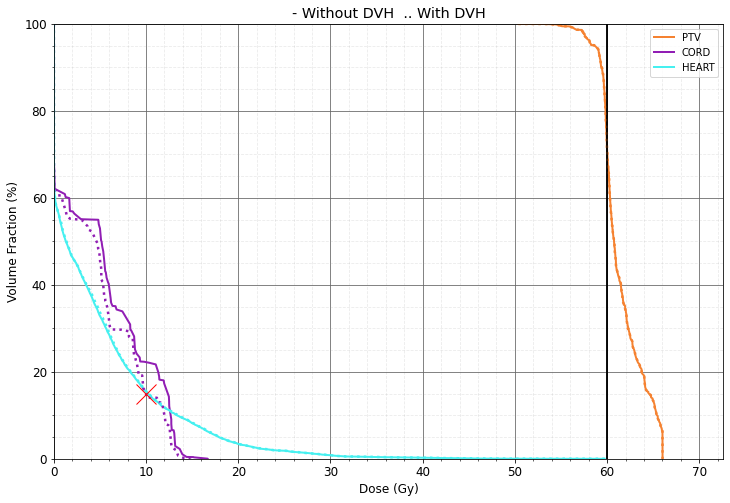

Done!


In [6]:
fig, ax = plt.subplots(figsize=(12, 8))
struct_names = ['PTV', 'ESOPHAGUS', 'HEART', 'CORD']
ax = pp.Visualization.plot_dvh(my_plan, sol=sol_no_dvh, struct_names=struct_names, style='solid', ax=ax)
ax = pp.Visualization.plot_dvh(my_plan, sol=sol_dvh, struct_names=struct_names, style='dotted', ax=ax)
ax.plot(dose_gy, limit_volume_perc, marker='x', color='red', markersize=20)
ax.set_title('- Without DVH  .. With DVH')
plt.show()
print('Done!')